# OTC Bitcoin Marketplace Rating Predictions

In [102]:
import pandas as pd
import numpy as np
import datetime
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

In [103]:
# Load data 
otc_df = h.load_bitcoin_edge_data('../data/soc-sign-bitcoinotc.csv.gz')

# Load preprocess features
df_otc_features = pd.read_csv('../data/df_features_otc.csv')
df_otc_velocity = pd.read_csv('../data/df_otc_vd.csv')

merge_cols = ['ratee','rater','date','rating','class']
features_df = pd.merge(df_otc_features, df_otc_velocity, on=merge_cols)
features_df.drop(['binomial_rating', 'color', 'penwidth'], inplace=True, axis=1)

### drop velocity features

In [104]:
velocity_cols = ['vel_24_in_pos','vel_24_in_all','vel_24_out_pos',
                 'vel_24_out_neg','vel_24_out_all','vel_24_all',
                 'vel_48_in_pos','vel_48_in_all','vel_48_out_pos',
                 'vel_48_out_neg','vel_48_out_all','vel_48_all'] 
features_df.drop(velocity_cols, inplace=True, axis=1)

### Random Forest Classifier

In [107]:
X = features_df.copy()
X = X.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = X.pop('class')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, shuffle=True,
                                                    random_state=123)

RF = RandomForestClassifier(n_jobs=-1, random_state=123)
RF.fit(X_train, y_train)
y_preds = RF.predict(X_test)
recall = recall_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
RF.feature_importances_

Recall: 0.5297418630751964
Precision: 0.8109965635738832


array([0.01860441, 0.03722324, 0.02184222, 0.11695053, 0.11888501,
       0.09094446, 0.05163884, 0.05192537, 0.05446381, 0.09490893,
       0.01630384, 0.01584243, 0.02450624, 0.0140141 , 0.02686423,
       0.02545155, 0.02502995, 0.02722609, 0.02166095, 0.0226645 ,
       0.05830643, 0.06474286])

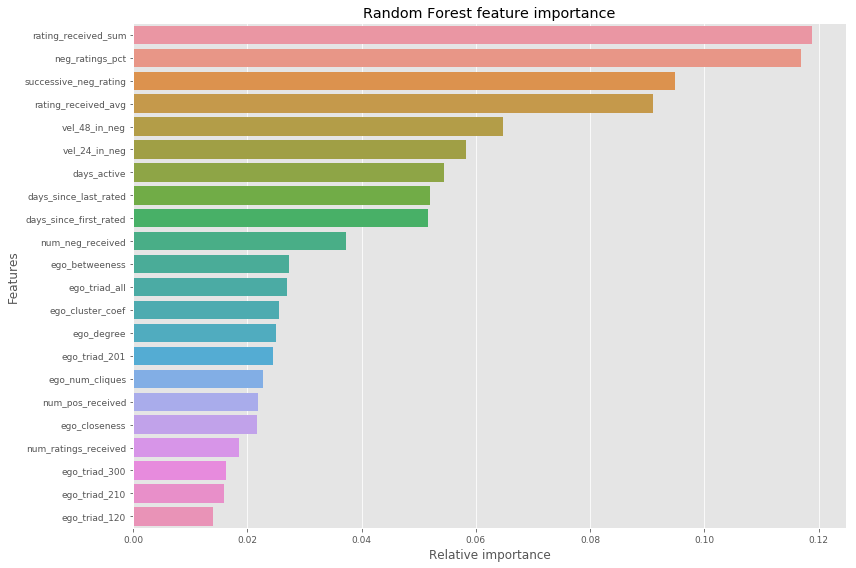

In [108]:
import seaborn as sns
fig = plt.figure(figsize=(12,8))

name = "Random Forest"
indices = np.argsort(RF.feature_importances_)[::-1][:40]
ax1 = sns.barplot(y=X_train.columns[indices][:40],x = RF.feature_importances_[indices][:40] , orient='h')
ax1.set_xlabel("Relative importance",fontsize=12)
ax1.set_ylabel("Features",fontsize=12)
ax1.tick_params(labelsize=9)
ax1.set_title(name + " feature importance")
plt.tight_layout()

### Model Tuning

### Model Exploration

In [ ]:
import shap
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(val_X)
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

### Example of collusion fraud

In [85]:
features_df[features_df['ratee']==4986]

,rater,ratee,rating,date,class,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_received_sum,rating_received_avg,days_since_first_rated,days_since_last_rated,days_active,successive_neg_rating,ego_triad_300,ego_triad_210,ego_triad_201,ego_triad_120,ego_triad_all,ego_cluster_coef,ego_degree,ego_betweeness,ego_closeness,ego_num_cliques,vel_24_in_neg,vel_48_in_neg


In [101]:
# THis is the example!!!
example_user = X[(features_df['ratee']==4986)].copy()
preds = RF.predict_proba(example_user)[:,1]
example_user['prediction'] = preds
example_user

,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_received_sum,rating_received_avg,days_since_first_rated,days_since_last_rated,days_active,successive_neg_rating,ego_triad_300,ego_triad_210,ego_triad_201,ego_triad_120,ego_triad_all,ego_cluster_coef,ego_degree,ego_betweeness,ego_closeness,ego_num_cliques,vel_24_in_neg,vel_48_in_neg,prediction
28678,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.068631
28701,1.0,0.0,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.069282
28707,2.0,0.0,2.0,0.000000,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,4.0,1.000000,1.000000,2.0,0.0,0.0,0.023366
28718,3.0,0.0,3.0,0.000000,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,0.333333,6.0,0.666667,1.000000,2.0,0.0,0.0,0.445000
28721,4.0,0.0,4.0,0.000000,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,6.0,0.166667,8.0,0.833333,1.000000,3.0,0.0,0.0,0.035000
28729,5.0,0.0,5.0,0.000000,5.0,1.0,2.0,0.0,2.0,0.0,1.0,1.0,6.0,0.0,8.0,0.187500,9.0,0.725000,0.833333,4.0,0.0,0.0,0.690000
28731,6.0,1.0,5.0,0.166667,-3.0,-0.5,2.0,0.0,2.0,0.0,1.0,1.0,6.0,0.0,8.0,0.187500,9.0,0.725000,0.833333,4.0,1.0,1.0,0.680000


In [45]:
example_user = X[(features_df['ratee']==4524)].copy()
preds = RF.predict_proba(example_user)[:,1]
example_user['prediction'] = preds
example_user[:10]

,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_received_sum,rating_received_avg,days_since_first_rated,days_since_last_rated,days_active,successive_neg_rating,ego_triad_300,ego_triad_210,ego_triad_201,ego_triad_120,ego_triad_all,ego_cluster_coef,ego_degree,ego_betweeness,ego_closeness,ego_num_cliques,vel_24_in_neg,vel_48_in_neg,prediction
24474,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.071278
25221,1.0,0.0,1.0,0.000000,3.0,3.00,19.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.015000
27312,2.0,0.0,2.0,0.000000,5.0,2.50,54.0,54.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.0,0.500000,0.500000,2.0,0.0,0.0,0.010000
27483,3.0,0.0,3.0,0.000000,6.0,2.00,60.0,41.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.0,0.333333,0.333333,3.0,0.0,0.0,0.010000
28088,4.0,0.0,4.0,0.000000,11.0,2.75,92.0,37.0,92.0,0.0,0.0,1.0,1.0,0.0,2.0,0.153846,6.0,0.583333,0.562500,3.0,0.0,0.0,0.670000
28091,5.0,1.0,4.0,0.200000,1.0,0.20,92.0,32.0,92.0,0.0,0.0,1.0,1.0,0.0,2.0,0.153846,6.0,0.583333,0.562500,3.0,1.0,1.0,0.880000
33203,6.0,2.0,4.0,0.333333,-9.0,-1.50,386.0,293.0,386.0,1.0,0.0,2.0,2.0,0.0,4.0,0.307692,6.0,0.500000,0.666667,3.0,0.0,0.0,0.600000


In [34]:
X_test[(y_preds==1)&(y_test==1)&(X_test['ego_triad_all']>3)&(X_test['ego_triad_all']<10)].head()

,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_received_sum,rating_received_avg,days_since_first_rated,days_since_last_rated,days_active,successive_neg_rating,ego_triad_300,ego_triad_210,ego_triad_201,ego_triad_120,ego_triad_all,ego_cluster_coef,ego_degree,ego_betweeness,ego_closeness,ego_num_cliques,vel_24_in_neg,vel_48_in_neg
14277,7.0,3.0,4.0,0.428571,0.0,0.000000,2.0,0.0,2.0,1.0,1.0,0.0,2.0,4.0,7.0,0.388889,7.0,0.500000,0.800000,2.0,2.0,2.0
14093,5.0,2.0,3.0,0.400000,4.0,0.800000,1.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,4.0,0.833333,6.0,0.083333,1.000000,1.0,2.0,2.0
33203,6.0,2.0,4.0,0.333333,-9.0,-1.500000,386.0,293.0,386.0,1.0,0.0,2.0,2.0,0.0,4.0,0.307692,6.0,0.500000,0.666667,3.0,0.0,0.0
33227,7.0,1.0,6.0,0.142857,-4.0,-0.571429,573.0,340.0,573.0,0.0,0.0,0.0,3.0,1.0,4.0,0.045455,9.0,0.466667,0.500000,5.0,0.0,0.0
26486,11.0,7.0,4.0,0.636364,-66.0,-6.000000,9.0,0.0,9.0,3.0,4.0,0.0,0.0,0.0,4.0,0.666667,7.0,0.250000,0.750000,2.0,3.0,3.0


In [44]:
features_df[(features_df['rating_received_sum']==-9)&(features_df['num_ratings_received']==6)
           &(features_df['num_neg_received']==2)]

,rater,ratee,rating,date,class,num_ratings_received,num_neg_received,num_pos_received,neg_ratings_pct,rating_received_sum,rating_received_avg,days_since_first_rated,days_since_last_rated,days_active,successive_neg_rating,ego_triad_300,ego_triad_210,ego_triad_201,ego_triad_120,ego_triad_all,ego_cluster_coef,ego_degree,ego_betweeness,ego_closeness,ego_num_cliques,vel_24_in_neg,vel_48_in_neg
33203,3988,4524,-5,2014-07-28 01:34:15,1,6.0,2.0,4.0,0.333333,-9.0,-1.5,386.0,293.0,386.0,1.0,0.0,2.0,2.0,0.0,4.0,0.307692,6.0,0.5,0.666667,3.0,0.0,0.0


In [109]:
# Look for malicious bot ratings
df2 = df_otc_features.copy()
df2['date'] = pd.to_datetime(df2['date'])
df3 = df2[(df2['date']>='2013-08-15') & (df2['date']<'2013-08-16')]
df3.groupby('ratee')['rating'].sum()

ratee
1         7
35       10
57        1
62        5
1334      2
1529      3
1832      2
2322    -18
2584      4
2600      1
2942      2
3005      1
3013      2
3317      1
3465      2
3527      1
3837      7
3897   -259
3903      4
4198      1
4320      1
4353      1
4458      1
4478      1
4531   -100
4649      3
4654   -100
4661   -100
4666   -100
4667    -70
4668    -70
4669   -100
4672   -100
4673   -100
4675    -80
4676   -100
4677   -100
4678   -100
4679   -100
4680   -100
4681   -100
4682   -100
4683   -100
4684   -100
4686   -110
4688   -110
4694      2
4701   -100
4707   -110
4733   -100
4743   -100
4744   -110
4746      1
4747   -110
4753      2
4754      1
4755      1
Name: rating, dtype: int64